# Unsupervised Learning and $K$-Means Clustering

**Unsupervised Learning.** In some pattern recognition problems, the training data consists of a set of input vectors x without any corresponding target values. The goal in such unsupervised learning problems may be to discover groups of similar examples within the data, where it is called clustering, or to determine how the data is distributed in the space, known as density estimation. To put forward in simpler terms, for a $n$-sampled space $x_1$ to $x_n$, true class labels are not provided for each sample, hence known as learning without teacher.


**Issues with Unsupervised Learning:**
* Unsupervised Learning is harder as compared to Supervised Learning tasks..
* How do we know if results are meaningful since no answer labels are available?
* Let the expert look at the results (external evaluation)
* Define an objective function on clustering (internal evaluation)

**What is Clustering?**

Clustering can be considered the most important unsupervised learning problem; so, as every other problem of this kind, it deals with finding a structure in a collection of unlabeled data. A loose definition of clustering could be “the process of organizing objects into groups whose members are similar in some way”. A cluster is therefore a collection of objects which are “similar” between them and are “dissimilar” to the objects belonging to other clusters.

For this notebook we will need the following packages:
 * Statistics [documentation](https://docs.julialang.org/en/v1/stdlib/Statistics/)
 * Plots [documentation](http://docs.juliaplots.org/latest/)
 
---

In [1]:
using Statistics
using Plots
theme(:dark)

---

In the code cell below we generate artificial data that mimics clustered and unlabeled data. For this test of artificial data we assume all points in a given cluster lie within some circle of a given radius and center. 

---

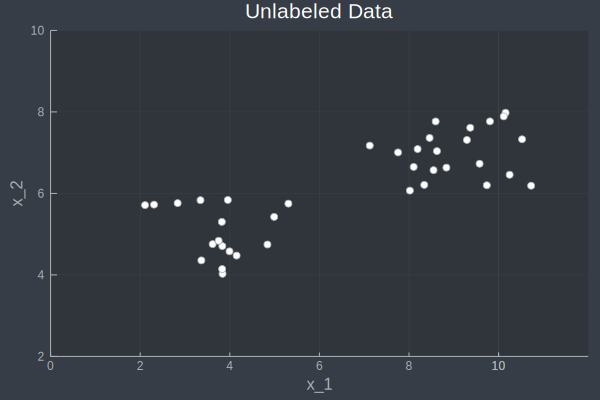

In [2]:
# How to form a circle! 
function circleShape(h, k, r)
    θ = LinRange(0, 2*π, 500)
    return h.+r*sin.(θ), k.+r*cos.(θ)
end


# Assume the center of cluster1 is (4, 5) with radius 1.8
cluster1 = [(4 + (-1)^rand(1:2)*rand(1:2)*rand(), 5 + (-1)^rand(1:2)*rand(1:1.5)*rand())
            for _ = 1:17]

# Assume the center of cluster2 is (9, 7) with radius 2.2
cluster2 = [(9 + (-1)^rand(1:2)*rand(1:2)*rand(), 7 + (-1)^rand(1:2)*rand(1:1.5)*rand())
            for _ = 1:21]

# Make the full data set of unlabeled points
data = copy(cluster1)
for x in cluster2
    push!(data, x)
end

# Plot the data
plot(legend = false, 
    xlabel = "x_1", 
    xlim = (0, 12),
    ylabel = "x_2",
    ylim = (2, 10), 
    title = "Unlabeled Data")

scatter!(data, color = "white")

---

The goal of the $K$-means algorithm is to find groups in the data that are clustered by distance, with the number of groups represented by the variable $K$. The algorithm works iteratively to assign each data point to one of $K$ groups based on the features that are provided. Data points are clustered based on feature similarity. The results of the $K$-means clustering algorithm are:

1. The centroids of the $K$ clusters are used to label new data 
2. Labels for the training data (each data point is assigned to a single cluster)

Rather than defining groups before looking at the data, clustering allows you to find and analyze the groups that have formed organically. Each centroid of a cluster is a collection of feature values which define the resulting groups. Examining the centroid feature weights can be used to qualitatively interpret what kind of group each cluster represents. 

Because we know the limits on the above experimental data (code cell [2]), as well as the appropriate value for $K$ ($K = 2$),  we can show a plot with two circles enclosing the points we have produced. The following code cell illustrates how to show this plot. By using the $K$-means algorithm we automatically generate these circles without using prior knowledge about which data points belong to which circle.

---

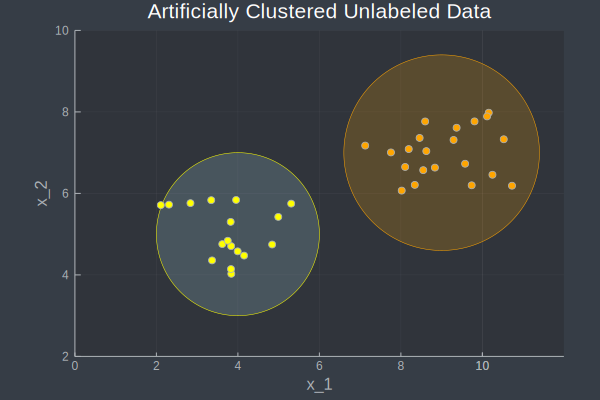

In [3]:
plot(legend = false,
    xlabel = "x_1", 
    xlim = (0, 12),
    ylabel = "x_2",
    ylim = (2, 10), 
    title = "Artificially Clustered Unlabeled Data")


plot!(circleShape(4, 5, 2.0), 
    seriestype = [:shape, ], 
    lw = 0.5, 
    c = "lightblue", 
    linecolor = "yellow", 
    legend = false, 
    fillalpha = 0.2, 
    aspect_ratio = 1,)

plot!(circleShape(9, 7, 2.4), 
    seriestype = [:shape, ], 
    lw = 0.5, 
    c = "orange", 
    linecolor = "orange", 
    legend = false, 
    fillalpha = 0.2, 
    aspect_ratio = 1)

scatter!(cluster1, 
        color = "yellow", 
        legend = false)
scatter!(cluster2, 
        legend = false, 
        color = "orange")

---

For our distance measure we will use the Euclidean distance:

$$
 d\left( p,q\right)   = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 } 
$$

---

In [4]:
# Define the Euclidean distance as a function
function euclidean_distance(p1, p2)
    return sqrt(sum([(p1[i] - p2[i])^2 for i = 1:length(p1)]))
end;

---

Let $X$ denote the collection of unlabeled data, and $C = c_1, \dots, c_K$ denote the collection of $K$ centroids $c_1$. At each iteration of the $K$-means algorithm we need to calculate the distance from each point in $X$ to each centroid $c_i$, for $i = 1, \dots, K$. A function for this is shown in the following code cell. 

---

In [5]:
function k_means_distances(X, centroids, k)
    distances = Dict()
    for p in X
        temp_dict = Dict()
        for i = 1:k
            temp_dict[i] = euclidean_distance(p, centroids[i])
        end
        distances[p] = temp_dict
    end
    return distances
end;

---

After calculating the distance to each centroid, the $K$-means algorithm then assigns each data point in $X$ to a centroid. This assignment is done according to:

$$
\underset{c_i \in C}{\mathrm{argmin}} \text{  }d(c_i, x), 
$$

where $x\in X$. A function for this is shown in the following code cell. 

---

In [6]:
function k_means_clusters(X, centroids, k)
    distances = k_means_distances(X, centroids, k)
    clusters = Dict()
    for p in X
        clusters[p] = 1
        min_d = distances[p][1]
        for i = 2:k
            if distances[p][i] < min_d
                clusters[p] = i
            end
        end
    end
    return clusters
end;

---

Once points in $X$ have been assigned to a given centroid in $C$, the $K$-means algorithm has essentially assigned current labels to all points in $X$ at this iteration. Let $S_i$ denote the set of all points in $X$ that have currently been assigned to the centroid $c_i$. The algorithm next updates the centroids in $C$ according to the mean of the points in $S_i$:

$$
c_i = \frac{1}{|S_i|}\underset{x \in S_i}\sum x
$$

A function for computing the new centers (of 2-dimentional data) is shown in the following code cell. 

---

In [7]:
function k_means_new_centroids(X, centroids, k)  
    clusters = k_means_clusters(X, centroids, k)
    new_centers = []
    for j = 1:k
        x = mean([p[1] for p in keys(clusters) if clusters[p] == j])
        y = mean([p[2] for p in keys(clusters) if clusters[p] == j])
        point = (x, y)
        push!(new_centers, point)
    end
    return new_centers
end;

In [8]:
# Test your functions!
centroids_test = k_means_new_centroids(data, 
                                      [(rand(1:10), rand(1:10)), (rand(1:10), rand(1:10))],
                                      2)
for x in centroids_test
    println(x)
end

(7.778253121785801, 6.7277748971165305)
(4.003249191884856, 4.668228700712061)


---
**Stopping Criteria for $K$-Means Clustering**

There are essentially three stopping criteria that can be adopted to stop the $K$-means algorithm:
1. Centroids of newly formed clusters do not change
2. Points remain in the same cluster
3. Maximum number of iterations are reached

We can stop the algorithm if the centroids of newly formed clusters are not changing. Even after multiple iterations, if we are getting the same centroids for all the clusters, we can say that the algorithm is not learning any new pattern and it is a sign to stop the training.

Another clear sign that we should stop the training process if the points remain in the same cluster even after training the algorithm for multiple iterations.

Finally, we can stop the training if the maximum number of iterations is reached. Suppose if we have set the number of iterations as 100. The process will repeat for 100 iterations before stopping.

For our code we choose to stop when the centers do not change distance within some small positive number $\epsilon > 0$. 

---

In [9]:
function k_means_algorithm(X, k, ϵ)
    
    # The following code ensures that each initial center is assigned a unique cluster
    centroids = []
    x_lims = []
    y_lims = []
    sort!(X, by = x->x[1])
    push!(x_lims, X[1][1])
    push!(x_lims, X[end][1])
    sort!(X, by = x->x[2])
    push!(y_lims, X[1][2])
    push!(y_lims, X[end][2])
    m_x = (x_lims[2]-x_lims[1])/k
    m_y = (y_lims[2] -y_lims[1])/k
    centroids = [(x_lims[1], y_lims[1])]
 
    
    for i = 1:k
        push!(centroids, (centroids[i][1] + m_x, centroids[i][2] + m_y))
    end

    # Now for the K-Means algorithm 
    new_centroids = k_means_new_centroids(X, centroids, k)
    while maximum([euclidean_distance(centroids[i], new_centroids[i]) for i = 1:k]) > ϵ
        centroids, new_centroids = new_centroids, k_means_new_centroids(X, new_centroids, k)
    end
    return new_centroids
end;

In [10]:
# Test your function!
k_means_algorithm(data, 2, 0.1)

2-element Array{Any,1}:
 (3.7587415047643966, 5.057190471178805)
 (9.054760467521684, 7.001342853330444) 

---

Once the centroids have converged to stable positions, we can now classify points as belonging to one of the $K$ clusters. This allows us to write a functions for predictions shown in the following code cell. 

---

In [11]:
function predict(point, X, k, ϵ)
    centroids = k_means_algorithm(X, k, ϵ)
    clusters = k_means_clusters(X, centroids, k)
    print("Predicted class of point ", string(point), " is ")
    println("Class ", string(clusters[point]))
end;

In [12]:
# Again, test your function!
predict(data[1], data, 2, 0.1)

Predicted class of point (3.838206382602999, 4.026713235718356) is Class 1


---

With the next code cell we can visualize the clustering circles generated by the $K$-means algorithm for our original artificial data. 

---

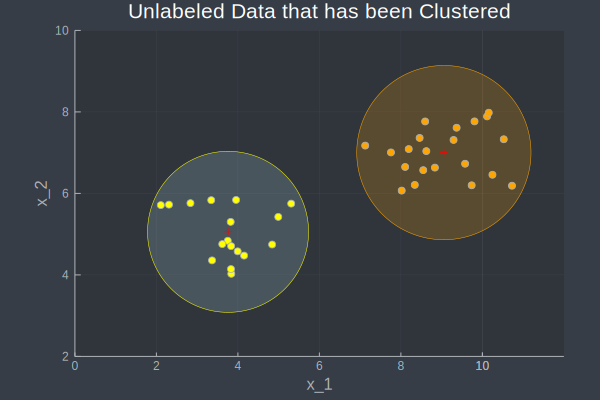

In [13]:
centroids = k_means_algorithm(data, 2, 0.1)
p1 = centroids[1]
p2 = centroids[2]

clusters = k_means_clusters(data, centroids, 2)

radius1 = maximum([euclidean_distance(p, p1) for p in keys(clusters) if clusters[p] == 1]) + .2
radius2 = maximum([euclidean_distance(p, p2) for p in keys(clusters) if clusters[p] == 2]) + .2

plot(legend = false, 
    xlabel = "x_1", 
    xlim = (0, 12),
    ylabel = "x_2",
    ylim = (2, 10), 
    title = "Unlabeled Data that has been Clustered")

plot!(circleShape(p1[1], p1[2], radius1), 
    seriestype = [:shape, ], 
    lw = 0.5, 
    c = "lightblue", 
    linecolor = "yellow", 
    legend = false, 
    fillalpha = 0.2, 
    aspect_ratio = 1)

plot!(circleShape(p2[1], p2[2], radius2), 
    seriestype = [:shape, ], 
    lw = 0.5, 
    c = "orange", 
    linecolor = "orange", 
    legend = false, 
    fillalpha = 0.2, 
    aspect_ratio = 1)

scatter!([x for x in keys(clusters) if clusters[x] == 1], 
        color = "yellow", 
        legend = false)
scatter!([x for x in keys(clusters) if clusters[x] == 2], 
        legend = false, 
        color = "orange")
scatter!([x for x in centroids], shape = :+, color = "red")

---

Next we perform the same task as above on an set of artifically created data set of 3 clusters. 

---

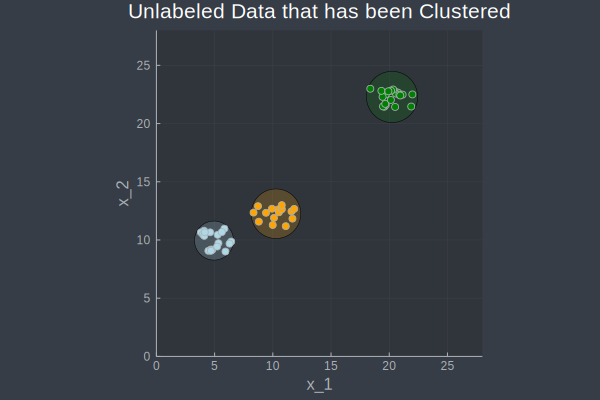

In [14]:
# Assume the center cluster1 is (5, 10)
cluster1 = [( 5+ (-1)^rand(1:2)*rand(1:2)*rand(), 10 + (-1)^rand(1:2)*rand(1:1.5)*rand())
            for _ = 1:19]

# Assume the center of cluster2 is (10, 12)
cluster2 = [(10 + (-1)^rand(1:2)*rand(1:2)*rand(), 12 + (-1)^rand(1:2)*rand(1:1.5)*rand())
            for _ = 1:15]

# Assume the center of cluster3 is (20, 22)
cluster3 = [(20 + (-1)^rand(1:2)*rand(1:2)*rand(), 22 + (-1)^rand(1:2)*rand(1:1.5)*rand())
            for _ = 1:21]

data = copy(cluster1)
for x in cluster2
    push!(data, x)
end
for x in cluster3
    push!(data, x)
end

centroids = k_means_algorithm(data, 3, 0.1)
p1 = centroids[1]
p2 = centroids[2]
p3 = centroids[3]

clusters = k_means_clusters(data, centroids, 3)

radius1 = maximum([euclidean_distance(p, p1) for p in keys(clusters) if clusters[p] == 1]) + .2
radius2 = maximum([euclidean_distance(p, p2) for p in keys(clusters) if clusters[p] == 2]) + .2
radius3 = maximum([euclidean_distance(p, p3) for p in keys(clusters) if clusters[p] == 3]) + .2
plot(legend = false, 
    xlabel = "x_1", 
    xlim = (0, 28),
    ylabel = "x_2",
    ylim = (0, 28), 
    title = "Unlabeled Data that has been Clustered")


plot!(circleShape(p1[1], p1[2], radius1), 
    seriestype = [:shape, ], 
    lw = 0.5, 
    c = "lightblue", 
    linecolor = "black", 
    legend = false, 
    fillalpha = 0.2, 
    aspect_ratio = 1)

plot!(circleShape(p2[1], p2[2], radius2), 
    seriestype = [:shape, ], 
    lw = 0.5, 
    c = "orange", 
    linecolor = "black", 
    legend = false, 
    fillalpha = 0.2, 
    aspect_ratio = 1)

plot!(circleShape(p3[1], p3[2], radius3), 
    seriestype = [:shape, ], 
    lw = 0.5, 
    color = "green", 
    linecolor = "black", 
    legend = false, 
    fillalpha = 0.2, 
    aspect_ratio = 1)
scatter!([x for x in keys(clusters) if clusters[x] == 1], 
        color = "lightblue", 
        legend = false)
scatter!([x for x in keys(clusters) if clusters[x] == 2], 
        legend = false, 
        color = "orange")
scatter!([x for x in keys(clusters) if clusters[x] == 3], 
        legend = false, 
        color = "green")

---

**Conclusion**

$K$-means clustering is one of the most popular clustering algorithms and usually the first thing practitioners apply when solving clustering tasks to get an idea of the structure of the dataset. The goal of $K$-kmeans is to group data points into distinct non-overlapping subgroups. It does a very good job when the clusters have a kind of spherical shapes. However, it suffers as the geometric shapes of clusters deviates from spherical shapes. Moreover, it also doesn’t learn the number of clusters from the data and requires it to be pre-defined. To be a good practitioner, it’s good to know the assumptions behind algorithms/methods so that you would have a pretty good idea about the strength and weakness of each method. This will help you decide when to use each method and under what circumstances. In this post, we covered both strength, weaknesses, and some evaluation methods related to $K$-means.

---